In [1]:
import tempfile
from typing import Dict, Iterable, List, Tuple

import allennlp
import torch
from allennlp.data import DataLoader, DatasetReader, Instance, Vocabulary
from allennlp.data.fields import LabelField, TextField
from allennlp.data.token_indexers import TokenIndexer, PretrainedTransformerIndexer
from allennlp.data.tokenizers import Token, Tokenizer, PretrainedTransformerTokenizer
from allennlp.models import Model
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder
from allennlp.modules.token_embedders import PretrainedTransformerEmbedder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.seq2vec_encoders import BertPooler
from allennlp.nn import util
from allennlp.training.trainer import GradientDescentTrainer, Trainer
from allennlp.training.optimizers import AdamOptimizer
from allennlp.training.metrics import CategoricalAccuracy

from os.path import join as pathjoin
import pandas as pd
from allennlp.predictors import TextClassifierPredictor
from allennlp.training.metrics import CategoricalAccuracy
import numpy as np

In [2]:
DATA_DIR = '/home/mlepekhin/data'
MODELS_DIR = '/home/mlepekhin/models'
MODEL_ID = 'allennlp_rubert'
CHECKPOINTS_DIR = pathjoin(MODELS_DIR, MODEL_ID, 'checkpoints')
BEST_MODEL = pathjoin(CHECKPOINTS_DIR, 'best.th')

In [3]:
transformer_model = 'DeepPavlov/rubert-base-cased'
MAX_TOKENS = 510

In [4]:
class SimpleClassifier(Model):
    def __init__(self,
                 vocab: Vocabulary,
                 embedder: TextFieldEmbedder,
                 encoder: Seq2VecEncoder):
        super().__init__(vocab)
        self.embedder = embedder 
        num_labels = vocab.get_vocab_size("labels")
        self.encoder = encoder
        self.classifier = torch.nn.Linear(encoder.get_output_dim(), num_labels)
        self.accuracy = CategoricalAccuracy()
        

    def forward(self,
                text: Dict[str, torch.Tensor],
                label: torch.Tensor=None) -> Dict[str, torch.Tensor]:
        # Shape: (batch_size, num_tokens, embedding_dim)
        embedded_text = self.embedder(text)
        #print("embed shape", embedded_text.shape)
        # Shape: (batch_size, num_tokens)
        mask = util.get_text_field_mask(text)
        #print("mask shape", mask.shape)
        # Shape: (batch_size, encoding_dim)
        encoded_text = self.encoder(embedded_text, mask)
        # Shape: (batch_size, num_labels)
        logits = self.classifier(encoded_text)
        # Shape: (batch_size, num_labels)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        if label is not None:
            loss = torch.nn.functional.cross_entropy(logits, label)
            self.accuracy(logits, label)
            return {'loss': loss, 'probs': probs}
        else:
            return {'probs': probs}
    
    def get_metrics(self, reset: bool = True) -> Dict[str, float]:
        return {"accuracy": self.accuracy.get_metric(reset)}

def read_data(reader: DatasetReader, train_path: str, val_path: str) -> Tuple[Iterable[Instance], Iterable[Instance]]:
    print("Reading data")
    training_data = reader.read(train_path)
    validation_data = reader.read(val_path)
    return training_data, validation_data


def build_vocab(instances: Iterable[Instance]) -> Vocabulary:
    print("Building the vocabulary")
    return Vocabulary.from_instances(instances)


def build_model(vocab: Vocabulary) -> Model:
    print("Building the model")
    vocab_size = vocab.get_vocab_size("tokens")
    #embedder = BasicTextFieldEmbedder(
    #    {"tokens": Embedding(embedding_dim=10, num_embeddings=vocab_size)})
    embedding = PretrainedTransformerEmbedder(model_name=transformer_model)
    embedder = BasicTextFieldEmbedder(token_embedders={'bert_tokens': embedding})
    encoder = BertPooler(transformer_model)
    return SimpleClassifier(vocab, embedder, encoder)

def build_dataset_reader() -> DatasetReader:
    return ClassificationDatasetReader()

def run_training_loop():
    dataset_reader = build_dataset_reader()

    # These are a subclass of pytorch Datasets, with some allennlp-specific
    # functionality added.
    train_data, dev_data = read_data(dataset_reader)

    vocab = build_vocab(train_data + dev_data)
    model = build_model(vocab)

    # This is the allennlp-specific functionality in the Dataset object;
    # we need to be able convert strings in the data to integers, and this
    # is how we do it.
    train_data.index_with(vocab)
    dev_data.index_with(vocab)

    # These are again a subclass of pytorch DataLoaders, with an
    # allennlp-specific collate function, that runs our indexing and
    # batching code.
    train_loader, dev_loader = build_data_loaders(train_data, dev_data)

    # You obviously won't want to create a temporary file for your training
    # results, but for execution in binder for this course, we need to do this.
    with tempfile.TemporaryDirectory() as serialization_dir:
        trainer = build_trainer(
            model,
            serialization_dir,
            train_loader,
            dev_loader
        )
        print("Starting training")
        trainer.train()
        print("Finished training")
    return trainer


# The other `build_*` methods are things we've seen before, so they are
# in the setup section above.
def build_data_loaders(
    train_data: torch.utils.data.Dataset,
    dev_data: torch.utils.data.Dataset,
) -> Tuple[allennlp.data.DataLoader, allennlp.data.DataLoader]:
    # Note that DataLoader is imported from allennlp above, *not* torch.
    # We need to get the allennlp-specific collate function, which is
    # what actually does indexing and batching.
    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    dev_loader = DataLoader(dev_data, batch_size=16, shuffle=False)
    return train_loader, dev_loader


def build_trainer(
    model: Model,
    serialization_dir: str,
    train_loader: DataLoader,
    dev_loader: DataLoader,
    num_epochs: int = 1,
    cuda_device: int = -1
) -> Trainer:
    parameters = [
        [n, p]
        for n, p in model.named_parameters() if p.requires_grad
    ]
    optimizer = AdamOptimizer(parameters, lr=0.000025)
    trainer = GradientDescentTrainer(
        model=model,
        serialization_dir=serialization_dir,
        data_loader=train_loader,
        validation_data_loader=dev_loader,
        num_epochs=num_epochs,
        optimizer=optimizer,
        cuda_device=cuda_device,
    )
    return trainer

In [5]:
tokenizer = PretrainedTransformerTokenizer(model_name=transformer_model)
token_indexer = PretrainedTransformerIndexer(model_name=transformer_model)
text = "Hello! I's no more than just my opinion. But I wanted to say you that I don't care"
tokens = tokenizer.tokenize(text)
print("Transformer tokens:", tokens)

Transformer tokens: [[CLS], hel, ##lo, !, i, ', s, no, more, than, just, my, op, ##ini, ##on, ., but, i, want, ##ed, to, say, you, that, i, don, ', t, car, ##e, [SEP]]


In [6]:
from allennlp.interpret.saliency_interpreters import SmoothGradient

In [7]:
class ClassificationDatasetReader(DatasetReader):
    def __init__(self,
                 lazy: bool = False,
                 tokenizer: Tokenizer = None,
                 token_indexers: Dict[str, TokenIndexer] = None,
                 max_tokens: int = None):
        super().__init__(lazy)
        self.tokenizer = tokenizer or PretrainedTransformerTokenizer(transformer_model, max_length=MAX_TOKENS)
        self.token_indexers = token_indexers or {'bert_tokens': PretrainedTransformerIndexer(transformer_model)}
        self.max_tokens = max_tokens
        
    def text_to_instance(self, string: str, label: str = None) -> Instance:
        tokens = self.tokenizer.tokenize(string)
        sentence_field = TextField(tokens, self.token_indexers)
        fields = {"text": sentence_field}
        if label is not None:
            fields["label"] = LabelField(label)
        return Instance(fields)

    def _read(self, file_path: str) -> Iterable[Instance]:
        dataset_df = pd.read_csv(file_path)
        for text, label in zip(dataset_df['text'], dataset_df['target']):
            yield self.text_to_instance(text, label)

### Loading of the pretrained model

In [8]:
vocab = Vocabulary().from_files(pathjoin(MODELS_DIR, MODEL_ID, 'vocab'))

In [9]:
print(vocab.get_token_to_index_vocabulary('labels'))

{'A8': 0, 'A12': 1, 'A1': 2, 'A14': 3, 'A11': 4, 'A17': 5, 'A16': 6, 'A4': 7, 'A9': 8, 'A7': 9}


In [10]:
model = build_model(vocab)

Building the model


In [11]:
model.load_state_dict(torch.load(BEST_MODEL))

<All keys matched successfully>

### Data loading

In [12]:
id_to_label = vocab.get_index_to_token_vocabulary('labels')
print(id_to_label)
print(id_to_label.values())

{0: 'A8', 1: 'A12', 2: 'A1', 3: 'A14', 4: 'A11', 5: 'A17', 6: 'A16', 7: 'A4', 8: 'A9', 9: 'A7'}
dict_values(['A8', 'A12', 'A1', 'A14', 'A11', 'A17', 'A16', 'A4', 'A9', 'A7'])


In [13]:
ru_test_df = pd.read_csv(pathjoin(DATA_DIR, 'ru_test'))
ru_test_df.head()

,Unnamed: 0,target,text
0,726,A7,Глава 1 Приступая к работе 1.1 Знакомство с те...
1,1871,A17,Kawasaki D-Tracker С недавних пор Kawasaki d-t...
2,1265,A17,"По моему , вполне достойные книги , может и не..."
3,205,A11,Тест-драйв Lada Granta : новая надежда автогра...
4,141,A8,"среда , 2 декабря 2009 года , 12.33 Бумага всё..."


In [14]:
true_classes = ru_test_df.target.values
sentences = ru_test_df.text.values

### Preliminary analysis

In [15]:
label_description = {
    'A1': 'argum',
    'A3': 'emotive',
    'A4': 'fictive',
    'A5': 'flippant',
    'A6': 'informal',
    'A7': 'instruct',
    'A8': 'reporting',
    'A9': 'legal',
    'A11': 'personal',
    'A12': 'commercial',
    'A13': 'propaganda',
    'A14': 'research',
    'A15': 'specialist',
    'A16': 'info',
    'A17': 'eval',
    'A19': 'poetic',
    'A20': 'appeal',
    'A22': 'stuff'
}

In [16]:
predictor = TextClassifierPredictor(model, dataset_reader=build_dataset_reader())

In [17]:
def predict_classes(sentence_list):
    return [id_to_label[np.argmax(predictor.predict(sentence)['probs'])] for sentence in sentence_list]

In [18]:
predicted_classes = np.array(predict_classes(sentences))

In [19]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

In [20]:
for label, description in label_description.items():
    true_binary = true_classes == label
    if np.sum(true_binary) == 0:
        continue
    predicted_binary = predicted_classes == label
    print(
        f"label ({description})", 
        f"f1_score {f1_score(predicted_binary, true_binary)}", 
        f"precision {precision_score(predicted_binary, true_binary)}", 
        f"recall {recall_score(predicted_binary, true_binary)}", 
    )
print(f"accuracy", accuracy_score(predicted_classes, true_classes))

label (argum) f1_score 0.7080745341614907 precision 0.7402597402597403 recall 0.6785714285714286
label (fictive) f1_score 0.7999999999999999 precision 0.8695652173913043 recall 0.7407407407407407
label (instruct) f1_score 0.8275862068965517 precision 0.7058823529411765 recall 1.0
label (reporting) f1_score 0.9483568075117371 precision 0.9805825242718447 recall 0.9181818181818182
label (legal) f1_score 0.8148148148148148 precision 0.8461538461538461 recall 0.7857142857142857
label (personal) f1_score 0.6516853932584269 precision 0.5918367346938775 recall 0.725
label (commercial) f1_score 0.9467455621301775 precision 0.9411764705882353 recall 0.9523809523809523
label (research) f1_score 0.8627450980392157 precision 0.8979591836734694 recall 0.8301886792452831
label (info) f1_score 0.4680851063829786 precision 0.3333333333333333 recall 0.7857142857142857
label (eval) f1_score 0.6582278481012658 precision 0.7647058823529411 recall 0.5777777777777777
accuracy 0.8095238095238095


In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

def plot_confusion_matrix(y_model, y_true):
    plt.figure(figsize=(15, 15))
    labels_list = list(id_to_label.values())
    cm = confusion_matrix(y_model, y_true, labels=labels_list)
    sums = np.sum(cm, axis=1)
    normed_cm = (cm.T / sums).T
    sns.heatmap(normed_cm)
    labels_descr = [label_description[label] for label in id_to_label.values()]
    plt.xticks(0.5 + np.arange(len(labels_list)), labels=labels_descr, fontsize=12)
    plt.yticks(0.5 + np.arange(len(labels_list)), labels=labels_descr, fontsize=12)

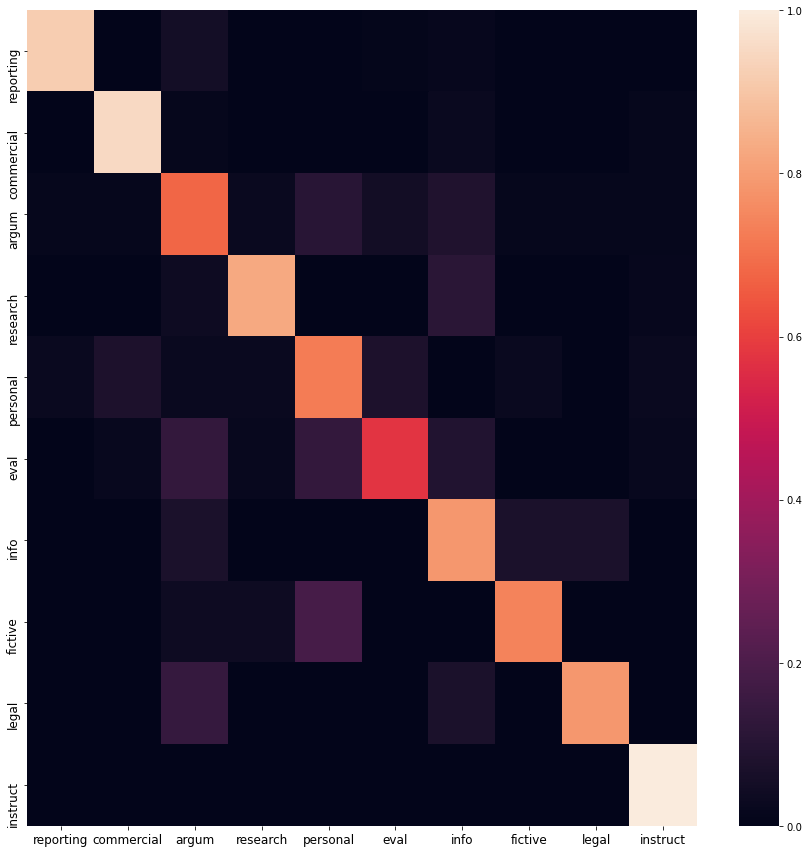

In [22]:
plot_confusion_matrix(predicted_classes, true_classes)

### Saliency Gradient Interpretation

In [23]:
from allennlp.interpret.saliency_interpreters import SmoothGradient, SimpleGradient, IntegratedGradient

In [24]:
smooth_grad = SmoothGradient(predictor)
simple_grad = SimpleGradient(predictor)
integrated_grad = IntegratedGradient(predictor)

In [25]:
def run_interpreter(sentence, tokens, k, interpreter):
    vec = np.array(interpreter.saliency_interpret_from_json({"sentence": sentence})['instance_1']['grad_input_1'])
    important_indices = set(vec.argsort()[-k:])
    
    print(type(interpreter), "TEXT:")
    for token_id, token in enumerate(tokens):
        if token_id in important_indices:
            print(colored(token , "red"), end=' ')
        else:
            print(token, end=' ')
    print("\n")

In [26]:
from termcolor import colored

def interpret_sentence(sentence, k, interpreters=[], true_label=None, label=None):
    if true_label is not None:
        print("TRUE LABEL:", true_label)
    if label is not None:
        print("LABEL:", label)
    
    tokens = tokenizer.tokenize(sentence)[1:511]
    k = min(k, len(tokens))
    for interpreter in interpreters:
        run_interpreter(sentence, tokens, k, interpreter)

In [27]:
mistake_ids = []

for sent_id in range(len(true_classes)):
    if true_classes[sent_id] != predicted_classes[sent_id]:
        mistake_ids.append(sent_id)

In [28]:
interpret_sentence(
    sentences[mistake_ids[0]], 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[0]]],
    label_description[predicted_classes[mistake_ids[0]]]
)

TRUE LABEL: personal
LABEL: eval
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
тест - дра ##ив la ##da gran ##ta : новая надежда авто ##града фактически , новая la ##da gran ##ta - это старая la ##da ka ##lin ##a плюс 400 новых дет ##але ##и . но назвать грант ##у всего лишь рест ##аи ##лингом калин ##ы язык не поверн ##ется . автомобиль деи ##ств ##ительно изменился и на самом деле стал лучше прежних продуктов автов ##аза . но поч ##ивать на лав ##рах тольят ##тин ##цам еще рано . ko ##les ##a . r u выяснили , почему . сюрприз ##ы поджид ##али еще до проб ##но ##и поездки на la ##da gran ##ta . провод ##ив меня к машине , сотрудник автос ##алона объяснил мне как пользоваться бр ##ел ##ком дополнительно ##и сигнализации : " если нажать на эту кнопку и немного подерж ##ать , двигатель завед ##ется ! " нажим ##ает . держит . не заводит ##ся . " наверное это из - за вашего коллеги , котор ##ы ##и открыл заднюю дверь , пока я жал на кнопку " . двер

In [29]:
interpret_sentence(
    sentences[mistake_ids[1]], 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[1]]],
    label_description[predicted_classes[mistake_ids[1]]]
)

TRUE LABEL: personal
LABEL: eval
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
я хотел бы рассказать немного о том , что мне нравится писать . я люблю погруж ##аться в тему , о котор ##ои пишу . мне нравится окун ##уться в тему с голово ##и и почувствовать себя таким подоп ##ыт ##ным кролик ##ом . я рассматрив ##аю свою жизнь как ряд экспериментов . ит ##ак , я работа ##ю в журнале es ##quir ##e , и пару лет назад я написал статью под названием " аутсор ##синг в мое ##и жизни " ; я нанял группу люд ##еи в банг ##ало ##ре , инди ##я , чтобы они прожили мою жизнь за меня . и они просматр ##ивали за меня мою электронную почту и отвечали на письма . они отвечали на мои телефонные звонки . они спор ##или вместо меня с мое ##и жен ##ои и читали моему сыну сказки на ночь . это был луч ##ши ##и месяц мое ##и жизни , потому что я просто сидел , читал книги и смотрел фильмы . это был чудес ##ны ##и опыт . позже , я написал для es ##quir ##e статью - - о 

In [30]:
interpret_sentence(
    sentences[mistake_ids[2]], 50, 
    [smooth_grad, simple_grad, integrated_grad],
    label_description[true_classes[mistake_ids[2]]],
    label_description[predicted_classes[mistake_ids[2]]]
)

TRUE LABEL: research
LABEL: argum
<class 'allennlp.interpret.saliency_interpreters.smooth_gradient.SmoothGradient'> TEXT:
когда мы смотри ##м новости , мы видим сообщения из ирак ##а , афган ##истана , с ##ьерра - ле ##оне , и кажется , что эти конфликты невозможно понять . именно так я и думал , когда начинал этот проект . но я физик , и поэтому решил на ##ити данные и попробовать разобраться . просто попробовать . ну и как на ##ив ##ны ##и новозеланд ##ец я подумал , что по ##иду в пента ##гон . не могли бы вы поделиться со мн ##ои информ ##аци ##еи ? ( смех ) нет . поэтому пришлось задуматься пос ##ерьез ##нее . и вот однажды вечером в оксфорд ##е я смотрел новости . и обратил внимание на экран под говоря ##щи ##ми головами . и обнаружил там информацию . там были данные , в ль ##ющихся на нас потока ##х новост ##еи . весь шум вокруг нас деи ##ств ##ительно содержит информацию . и мне пришла в голову мысль организовать нечто вроде разведки по открытым источникам . если ском ##бин ##и